In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [8]:
# Read the Timer Profiling data

# Directory path containing the files
directory = 'data'

# List to store individual DataFrames
dataframes = []

# categories
categories = ["catalyst", "checkpointing"]
sites = ['alcf']

# Iterate over each file in the directory
for site in sites:
    for cat in categories:
        path = os.path.join(directory, site, cat)
        for filename in os.listdir(path):
            if "Times" in filename and filename.endswith(".csv"):
                ranks = filename.split("-")[-1].split(".")[0]
                file_path = os.path.join(path, filename)
                data = pd.read_csv(file_path)
                data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
                data['total_ranks'] = ranks
                data['category'] = cat
                data['site'] = site
                dataframes.append(data)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Convert 'Total Ranks' to integers
df['total_ranks'] = df['total_ranks'].astype(int)

In [9]:
df.head()

,rank,thread,name,start_time,end_time,delta,bytes,depth,total_ranks,category,site
0,0,22942672990208,"""CatalystAnalysisAdaptor::Initialize""",1.691665e+09,1.691665e+09,0.238107,-1,3,280,catalyst,alcf
1,0,22942672990208,"""CatalystAnalysisAdaptor::0::Initialize""",1.691665e+09,1.691665e+09,0.000000,-1,3,280,catalyst,alcf
2,0,22942672990208,"""ConfigurableAnalysis::Initialize""",1.691665e+09,1.691665e+09,6.768321,-1,2,280,catalyst,alcf
3,0,22942672990208,"""ConfigurableAnalysis::Initialize""",1.691665e+09,1.691665e+09,6.783631,-1,1,280,catalyst,alcf
4,0,22942672990208,"""nek::sensei_bridge::initialize""",1.691665e+09,1.691665e+09,6.784141,-1,0,280,catalyst,alcf


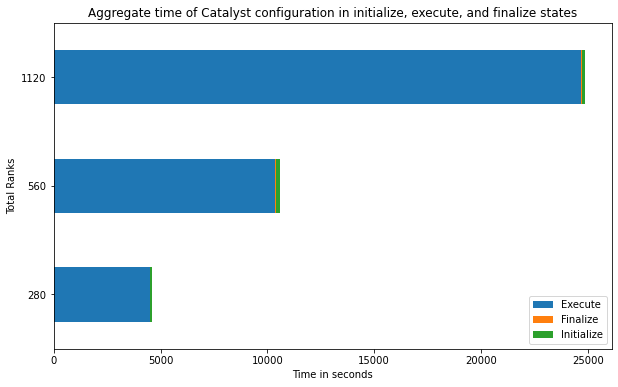

In [10]:
grouped_data = df[df['name'].str.contains('CatalystAnalysisAdaptor::Execute|CatalystAnalysisAdaptor::Initialize|CatalystAnalysisAdaptor::Finalize')]
grouped_data = grouped_data.groupby(['name', 'total_ranks', 'category', 'site'])['delta'].sum().reset_index()

def plot_mean_time_per_timestep(df):
    catalyst = df[df['category'] == 'catalyst']

    # Pivot the data to have 'rank' as columns and 'name' as index
    catalyst = catalyst.pivot(index='total_ranks', columns='name', values='delta')

    # Sort the index in ascending order
    catalyst.sort_index(ascending=True, inplace=True)

    ax = catalyst.plot(kind='barh', stacked=True, figsize=(10,6))

    # Set the title and labels
    ax.set_title('Aggregate time of Catalyst configuration in initialize, execute, and finalize states')
    ax.set_ylabel("Total Ranks")
    ax.legend(loc="lower right")
    ax.legend(['Execute', 'Finalize', 'Initialize'])

    ax.set_xlabel("Time in seconds")

    # Show the plot
    plt.show()
    
plot_mean_time_per_timestep(grouped_data[grouped_data['site'] == 'alcf'])
#plot_mean_time_per_timestep(grouped_data[grouped_data['site'] == 'julich'])

In [11]:
from statistics import mean 

dataframes = {}
# Iterate over each file in the directory
for site in sites:
    for cat in categories:
        path = os.path.join(directory, site, cat)
        for filename in os.listdir(path):
            if "MemProf" in filename and filename.endswith(".csv"):
                ranks = filename.split("-")[-1].split(".")[0]
                file_path = os.path.join(path, filename)
                data = pd.read_csv(file_path)
                data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
                data['total_ranks'] = ranks
                dataframes[site + cat + ranks] = data
                print("Adding " + site + " and " + cat + " and ranks " + ranks)

def calculate_memory_usage(df):
    memory_usage = {}

    index = 0
    N = df[df['rank'] == 0].count()['rank']
    res = df['memory_kib'].values.reshape(-1, N)
    res_time = df['time'].values.reshape(-1, N)
    total_sum = [sum(x) for x in zip(*res)]
    time = [mean(x) for x in zip(*res_time)]

    timestep = 0
    for ts in total_sum:
        memory_usage[str(index)] = {'memory_kib': ts, 'timestep': timestep, 'time': time[index]}
        timestep = timestep + 1
        index = index + 1
    #memory_usage
    memory_df = pd.DataFrame(memory_usage).transpose()
    # Covert to MB
    memory_df['memory_mb'] = memory_df['memory_kib'] / 1024

    # Covert to GB
    memory_df['memory_gb'] = memory_df['memory_mb'] / 1024
    
    return memory_df

Adding alcf and catalyst and ranks 560
Adding alcf and catalyst and ranks 1120
Adding alcf and catalyst and ranks 280
Adding alcf and checkpointing and ranks 560
Adding alcf and checkpointing and ranks 1120
Adding alcf and checkpointing and ranks 280


In [12]:
alcf_checkpointing_280 = calculate_memory_usage(dataframes['alcf' + 'checkpointing' + '280'])
alcf_checkpointing_560 = calculate_memory_usage(dataframes['alcf' + 'checkpointing' + '560'])
alcf_checkpointing_1120 = calculate_memory_usage(dataframes['alcf' + 'checkpointing' + '1120'])
alcf_catalyst_280 = calculate_memory_usage(dataframes['alcf' + 'catalyst' + '280'])
alcf_catalyst_560 = calculate_memory_usage(dataframes['alcf' + 'catalyst' + '560'])
alcf_catalyst_1120 = calculate_memory_usage(dataframes['alcf' + 'catalyst' + '1120'])

In [13]:
alcf_checkpointing_280["total_ranks"] = 280
alcf_checkpointing_560["total_ranks"] = 560
alcf_checkpointing_1120["total_ranks"] = 1120
alcf_catalyst_280["total_ranks"] = 280
alcf_catalyst_560["total_ranks"] = 560
alcf_catalyst_1120["total_ranks"] = 1120

alcf_checkpointing_280["category"] = "checkpointing"
alcf_checkpointing_560["category"] = "checkpointing"
alcf_checkpointing_1120["category"] = "checkpointing"
alcf_catalyst_280["category"] = "catalyst"
alcf_catalyst_560["category"] = "catalyst"
alcf_catalyst_1120["category"] = "catalyst"

df = pd.concat([alcf_checkpointing_280, alcf_checkpointing_560, alcf_checkpointing_1120, alcf_catalyst_280, alcf_catalyst_560, alcf_catalyst_1120], ignore_index=True)

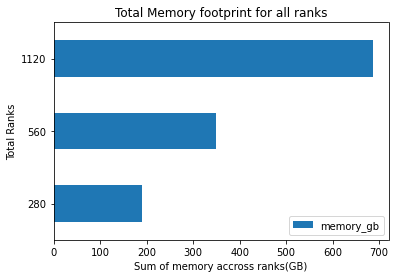

In [14]:
def plot_avg_memory(df):
    # Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
    sum_avg_memory = df.groupby('total_ranks')['memory_gb'].mean().reset_index()

    # Convert 'Total Ranks' to integers
    sum_avg_memory['total_ranks'] = sum_avg_memory['total_ranks'].astype(int)

    # Sort the index in ascending order
    sum_avg_memory = sum_avg_memory.sort_values('total_ranks')


    # Plot the sum of average memory_gb over time by 'total_ranks' with axes flipped
    sum_avg_memory.plot(kind='barh', x='total_ranks', y='memory_gb')
    #plt.barh()

    # Set the title and labels
    plt.title('Total Memory footprint for all ranks')
    plt.xlabel('Sum of memory accross ranks(GB)')
    plt.ylabel('Total Ranks')

    # Show the plot
    plt.show()
    
plot_avg_memory(df)

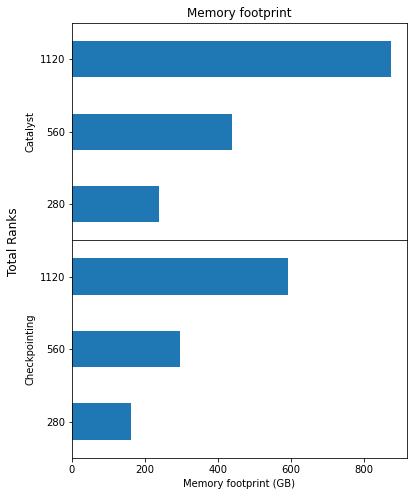

In [15]:
alcf_check_df = pd.concat([alcf_checkpointing_280, alcf_checkpointing_560, alcf_checkpointing_1120], ignore_index=True)
alcf_catalyst_df = pd.concat([alcf_catalyst_280, alcf_catalyst_560, alcf_catalyst_1120], ignore_index=True)

alcf_check_df = alcf_check_df.groupby('total_ranks')['memory_gb'].max().reset_index()
alcf_check_df['total_ranks'] = alcf_check_df['total_ranks'].astype(int)
alcf_check_df = alcf_check_df.sort_values('total_ranks')

alcf_catalyst_df = alcf_catalyst_df.groupby('total_ranks')['memory_gb'].max().reset_index()
alcf_catalyst_df['total_ranks'] = alcf_catalyst_df['total_ranks'].astype(int)
alcf_catalyst_df = alcf_catalyst_df.sort_values('total_ranks')


fig, axs = plt.subplots(2, figsize=(6,8), sharex=True)

# Plot the stacked bar graph with axes flipped
alcf_catalyst_df.plot(ax=axs[0], kind='barh', x='total_ranks', y='memory_gb')
alcf_check_df.plot(ax=axs[1], kind='barh', x='total_ranks', y='memory_gb')
#plt.barh()

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

for ax in axs:
    ax.yaxis.set_label_position('left')
    ax.get_legend().remove()
    ax.label_outer()

# Set the title and labels
axs[0].set_title('Memory footprint')
axs[0].set_ylabel("Catalyst")
axs[1].set_ylabel("Checkpointing")

axs[1].set_xlabel("Memory footprint (GB)")
plt.show()

    


In [16]:
# Iterate over each file in the directory
for site in sites:
    path = os.path.join(directory, site)
    file_path = os.path.join(path, "time_to_solution.csv")
    df = pd.read_csv(file_path)
    df['site'] = site
    
df

,ranks,category,time,checkpointing,calls,site
0,280,catalyst,290.542,0.00000,0,alcf
1,560,catalyst,293.416,0.00000,0,alcf
2,1120,catalyst,285.311,0.00000,0,alcf
3,280,checkpointing,246.349,2.52763,30,alcf
4,560,checkpointing,270.033,3.81195,30,alcf
5,1120,checkpointing,299.612,7.18338,30,alcf


/Users/vmateevitsi/opt/miniconda3/envs/jupyter/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


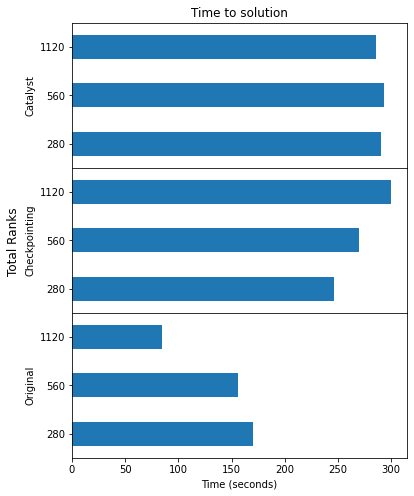

In [17]:

catalyst = df[df['category'] == 'catalyst']
#posthocio = df[df['category'] == 'posthocio']
checkpointing = df[df['category'] == 'checkpointing']
no_sensei = df[df['category'] == 'checkpointing']
no_sensei['time'] = no_sensei['time'] - (no_sensei['checkpointing'] * no_sensei['calls'])

# Sort the index in ascending order
catalyst.sort_index(ascending=True, inplace=True)
checkpointing.sort_index(ascending=True, inplace=True)
no_sensei.sort_index(ascending=True, inplace=True)

fig, axs = plt.subplots(3, figsize=(6,8), sharex=True)

# Plot the stacked bar graph with axes flipped
catalyst.plot(ax=axs[0], kind='barh', x='ranks', y='time')
checkpointing.plot(ax=axs[1], kind='barh', x='ranks', y='time')
no_sensei.plot(ax=axs[2], kind='barh', x='ranks', y='time')

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

for ax in axs:
    ax.yaxis.set_label_position('left')
    ax.get_legend().remove()
    ax.label_outer()

# Set the title and labels
axs[0].set_title('Time to solution')
axs[0].set_ylabel("Catalyst")
axs[1].set_ylabel("Checkpointing")
axs[2].set_ylabel("Original")

axs[2].set_xlabel("Time (seconds)")
plt.show()